# 集成学习案例一

**背景介绍**

此案例是一个数据挖掘类型的比赛——幸福感预测的baseline。比赛的数据使用的是官方的《中国综合社会调查（CGSS）》文件中的调查结果中的数据，其共包含有139个维度的特征，包括个体变量（性别、年龄、地域、职业、健康、婚姻与政治面貌等等）、家庭变量（父母、配偶、子女、家庭资本等等）、社会态度（公平、信用、公共服务）等特征

**数据信息**

赛题要求使用以上 139 维的特征，使用 8000 余组数据进行对于个人幸福感的预测（预测值为1，2，3，4，5，其中1代表幸福感最低，5代表幸福感最高）。 因为考虑到变量个数较多，部分变量间关系复杂，数据分为完整版和精简版两类。可从精简版入手熟悉赛题后，使用完整版挖掘更多信息。在这里我直接使用了完整版的数据。赛题也给出了index文件中包含每个变量对应的问卷题目，以及变量取值的含义；survey文件中为原版问卷，作为补充以方便理解问题背景。

**评价指标**

最终的评价指标为均方误差MSE

In [1]:
## Import packages
import os
import time 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import ExtraTreesRegressor as etr
from sklearn.linear_model import BayesianRidge as br
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import ElasticNet as en
from sklearn.kernel_ridge import KernelRidge as kr
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import logging
import warnings

warnings.filterwarnings('ignore') #消除warning

In [2]:
train = pd.read_csv("train.csv", parse_dates=['survey_time'],encoding='latin-1') 
test = pd.read_csv("test.csv", parse_dates=['survey_time'],encoding='latin-1') #latin-1向下兼容ASCII
train = train[train["happiness"]!=-8].reset_index(drop=True)
train_data_copy = train.copy() #删去"happiness" 为-8的行
target_col = "happiness" #目标列
target = train_data_copy[target_col]
del train_data_copy[target_col] #去除目标列

data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)

In [3]:
train.happiness.describe() #数据的基本信息

count    7988.000000
mean        3.867927
std         0.818717
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: happiness, dtype: float64

## Data Preprocessing

In [4]:
#make feature +5
#csv中有复数值：-1、-2、-3、-8，将他们视为有问题的特征，但是不删去
def getres1(row):
    return len([x for x in row.values if type(x)==int and x<0])

def getres2(row):
    return len([x for x in row.values if type(x)==int and x==-8])

def getres3(row):
    return len([x for x in row.values if type(x)==int and x==-1])

def getres4(row):
    return len([x for x in row.values if type(x)==int and x==-2])

def getres5(row):
    return len([x for x in row.values if type(x)==int and x==-3])

#检查数据
data['neg1'] = data[data.columns].apply(lambda row:getres1(row),axis=1)
data.loc[data['neg1']>20,'neg1'] = 20  #平滑处理

data['neg2'] = data[data.columns].apply(lambda row:getres2(row),axis=1)
data['neg3'] = data[data.columns].apply(lambda row:getres3(row),axis=1)
data['neg4'] = data[data.columns].apply(lambda row:getres4(row),axis=1)
data['neg5'] = data[data.columns].apply(lambda row:getres5(row),axis=1)

In [5]:
data

,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,neg1,neg2,neg3,neg4,neg5
0,1,1,12,32,59,2015-08-04 14:18:00,1,1959,1,1,...,30.0,30,50,50,50,5,3,0,2,0
1,2,2,18,52,85,2015-07-21 15:04:00,1,1992,1,1,...,85.0,70,90,60,60,0,0,0,0,0
2,3,2,29,83,126,2015-07-21 13:24:00,2,1967,1,0,...,80.0,90,90,90,75,3,1,0,2,0
3,4,2,10,28,51,2015-07-25 17:33:00,2,1943,1,1,...,80.0,90,90,80,80,2,0,0,2,0
4,5,1,7,18,36,2015-08-10 09:50:00,2,1994,1,1,...,50.0,50,50,50,50,2,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10951,10964,1,27,77,117,2015-07-19 20:01:00,2,1946,1,1,...,50.0,60,40,60,50,0,0,0,0,0
10952,10965,2,26,74,114,2015-08-08 13:09:00,2,1977,1,1,...,50.0,50,50,50,50,2,0,0,2,0
10953,10966,2,29,84,127,2015-07-22 09:29:00,2,1968,1,1,...,60.0,60,60,60,60,8,6,0,2,0
10954,10967,1,11,31,54,2015-07-20 16:06:00,1,1950,1,1,...,90.0,80,80,80,80,4,1,1,2,0


In [6]:
#填充缺失值 共25列 去掉4列 填充21列
#以下的列都是缺省的，视情况填补
data['work_status'] = data['work_status'].fillna(0)
data['work_yr'] = data['work_yr'].fillna(0)
data['work_manage'] = data['work_manage'].fillna(0)
data['work_type'] = data['work_type'].fillna(0)

data['edu_yr'] = data['edu_yr'].fillna(0)
data['edu_status'] = data['edu_status'].fillna(0)

data['s_work_type'] = data['s_work_type'].fillna(0)
data['s_work_status'] = data['s_work_status'].fillna(0)
data['s_political'] = data['s_political'].fillna(0)
data['s_hukou'] = data['s_hukou'].fillna(0)
data['s_income'] = data['s_income'].fillna(0)
data['s_birth'] = data['s_birth'].fillna(0)
data['s_edu'] = data['s_edu'].fillna(0)
data['s_work_exper'] = data['s_work_exper'].fillna(0)

data['minor_child'] = data['minor_child'].fillna(0)
data['marital_now'] = data['marital_now'].fillna(0)
data['marital_1st'] = data['marital_1st'].fillna(0)
data['social_neighbor']=data['social_neighbor'].fillna(0)
data['social_friend']=data['social_friend'].fillna(0)
data['hukou_loc']=data['hukou_loc'].fillna(1) #最少为1，表示户口
data['family_income']=data['family_income'].fillna(66365) #删除问题值后的平均值

In [7]:
#144+1 =145
#继续进行特殊的列进行数据处理
#读happiness_index.xlsx
data['survey_time'] = pd.to_datetime(data['survey_time'], format='%Y-%m-%d',errors='coerce')#防止时间格式不同的报错errors='coerce‘
data['survey_time'] = data['survey_time'].dt.year #仅仅是year，方便计算年龄
data['age'] = data['survey_time']-data['birth']
# print(data['age'],data['survey_time'],data['birth'])
#年龄分层 145+1=146
bins = [0,17,26,34,50,63,100]
data['age_bin'] = pd.cut(data['age'], bins, labels=[0,1,2,3,4,5])

In [8]:
data

,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,public_service_7,public_service_8,public_service_9,neg1,neg2,neg3,neg4,neg5,age,age_bin
0,1,1,12,32,59,2015,1,1959,1,1,...,50,50,50,5,3,0,2,0,56,4
1,2,2,18,52,85,2015,1,1992,1,1,...,90,60,60,0,0,0,0,0,23,1
2,3,2,29,83,126,2015,2,1967,1,0,...,90,90,75,3,1,0,2,0,48,3
3,4,2,10,28,51,2015,2,1943,1,1,...,90,80,80,2,0,0,2,0,72,5
4,5,1,7,18,36,2015,2,1994,1,1,...,50,50,50,2,1,1,0,0,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10951,10964,1,27,77,117,2015,2,1946,1,1,...,40,60,50,0,0,0,0,0,69,5
10952,10965,2,26,74,114,2015,2,1977,1,1,...,50,50,50,2,0,0,2,0,38,3
10953,10966,2,29,84,127,2015,2,1968,1,1,...,60,60,60,8,6,0,2,0,47,3
10954,10967,1,11,31,54,2015,1,1950,1,1,...,80,80,80,4,1,1,2,0,65,5


In [9]:
#对‘宗教’处理
data.loc[data['religion']<0,'religion'] = 1 #1为不信仰宗教
data.loc[data['religion_freq']<0,'religion_freq'] = 1 #1为从来没有参加过
#对‘教育程度’处理
data.loc[data['edu']<0,'edu'] = 4 #初中
data.loc[data['edu_status']<0,'edu_status'] = 0
data.loc[data['edu_yr']<0,'edu_yr'] = 0
#对‘个人收入’处理
data.loc[data['income']<0,'income'] = 0 #认为无收入
#对‘政治面貌’处理
data.loc[data['political']<0,'political'] = 1 #认为是群众
#对体重处理
data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2  #个人的想法，哈哈哈，没有60斤的成年人吧
#对身高处理
data.loc[data['height_cm']<150,'height_cm'] = 150 #成年人的实际情况
#对‘健康’处理
data.loc[data['health']<0,'health'] = 4 #认为是比较健康
data.loc[data['health_problem']<0,'health_problem'] = 4
#对‘沮丧’处理
data.loc[data['depression']<0,'depression'] = 4 #一般人都是很少吧
#对‘媒体’处理
data.loc[data['media_1']<0,'media_1'] = 1 #都是从不
data.loc[data['media_2']<0,'media_2'] = 1
data.loc[data['media_3']<0,'media_3'] = 1
data.loc[data['media_4']<0,'media_4'] = 1
data.loc[data['media_5']<0,'media_5'] = 1
data.loc[data['media_6']<0,'media_6'] = 1
#对‘空闲活动’处理
data.loc[data['leisure_1']<0,'leisure_1'] = 1 #都是根据自己的想法
data.loc[data['leisure_2']<0,'leisure_2'] = 5
data.loc[data['leisure_3']<0,'leisure_3'] = 3

In [10]:

data.loc[data['leisure_4']<0,'leisure_4'] = data['leisure_4'].mode() #取众数
data.loc[data['leisure_5']<0,'leisure_5'] = data['leisure_5'].mode()
data.loc[data['leisure_6']<0,'leisure_6'] = data['leisure_6'].mode()
data.loc[data['leisure_7']<0,'leisure_7'] = data['leisure_7'].mode()
data.loc[data['leisure_8']<0,'leisure_8'] = data['leisure_8'].mode()
data.loc[data['leisure_9']<0,'leisure_9'] = data['leisure_9'].mode()
data.loc[data['leisure_10']<0,'leisure_10'] = data['leisure_10'].mode()
data.loc[data['leisure_11']<0,'leisure_11'] = data['leisure_11'].mode()
data.loc[data['leisure_12']<0,'leisure_12'] = data['leisure_12'].mode()
data.loc[data['socialize']<0,'socialize'] = 2 #很少
data.loc[data['relax']<0,'relax'] = 4 #经常
data.loc[data['learn']<0,'learn'] = 1 #从不，哈哈哈哈
#对‘社交’处理
data.loc[data['social_neighbor']<0,'social_neighbor'] = 0
data.loc[data['social_friend']<0,'social_friend'] = 0
data.loc[data['socia_outing']<0,'socia_outing'] = 1
data.loc[data['neighbor_familiarity']<0,'social_neighbor']= 4
#对‘社会公平性’处理
data.loc[data['equity']<0,'equity'] = 4
#对‘社会等级’处理
data.loc[data['class_10_before']<0,'class_10_before'] = 3
data.loc[data['class']<0,'class'] = 5
data.loc[data['class_10_after']<0,'class_10_after'] = 5
data.loc[data['class_14']<0,'class_14'] = 2
#对‘工作情况’处理
data.loc[data['work_status']<0,'work_status'] = 0
data.loc[data['work_yr']<0,'work_yr'] = 0
data.loc[data['work_manage']<0,'work_manage'] = 0
data.loc[data['work_type']<0,'work_type'] = 0
#对‘社会保障’处理
data.loc[data['insur_1']<0,'insur_1'] = 1
data.loc[data['insur_2']<0,'insur_2'] = 1
data.loc[data['insur_3']<0,'insur_3'] = 1
data.loc[data['insur_4']<0,'insur_4'] = 1
data.loc[data['insur_1']==0,'insur_1'] = 0
data.loc[data['insur_2']==0,'insur_2'] = 0
data.loc[data['insur_3']==0,'insur_3'] = 0
data.loc[data['insur_4']==0,'insur_4'] = 0

In [11]:
#对家庭情况处理
family_income_mean = data['family_income'].mean()
data.loc[data['family_income']<0,'family_income'] = family_income_mean
data.loc[data['family_m']<0,'family_m'] = 2
data.loc[data['family_status']<0,'family_status'] = 3
data.loc[data['house']<0,'house'] = 1
data.loc[data['car']<0,'car'] = 0
data.loc[data['car']==2,'car'] = 0 #变为0和1
data.loc[data['son']<0,'son'] = 1
data.loc[data['daughter']<0,'daughter'] = 0
data.loc[data['minor_child']<0,'minor_child'] = 0
#对‘婚姻’处理
data.loc[data['marital_1st']<0,'marital_1st'] = 0
data.loc[data['marital_now']<0,'marital_now'] = 0
#对‘配偶’处理
data.loc[data['s_birth']<0,'s_birth'] = 0
data.loc[data['s_edu']<0,'s_edu'] = 0
data.loc[data['s_political']<0,'s_political'] = 0
data.loc[data['s_hukou']<0,'s_hukou'] = 0
data.loc[data['s_income']<0,'s_income'] = 0
data.loc[data['s_work_type']<0,'s_work_type'] = 0
data.loc[data['s_work_status']<0,'s_work_status'] = 0
data.loc[data['s_work_exper']<0,'s_work_exper'] = 0
#对‘父母情况’处理
data.loc[data['f_birth']<0,'f_birth'] = 1945
data.loc[data['f_edu']<0,'f_edu'] = 1
data.loc[data['f_political']<0,'f_political'] = 1
data.loc[data['f_work_14']<0,'f_work_14'] = 2
data.loc[data['m_birth']<0,'m_birth'] = 1940
data.loc[data['m_edu']<0,'m_edu'] = 1
data.loc[data['m_political']<0,'m_political'] = 1
data.loc[data['m_work_14']<0,'m_work_14'] = 2
#和同龄人相比社会经济地位
data.loc[data['status_peer']<0,'status_peer'] = 2
#和3年前比社会经济地位
data.loc[data['status_3_before']<0,'status_3_before'] = 2
#对‘观点’处理
data.loc[data['view']<0,'view'] = 4
#对期望年收入处理
data.loc[data['inc_ability']<=0,'inc_ability']= 2
inc_exp_mean = data['inc_exp'].mean()
data.loc[data['inc_exp']<=0,'inc_exp']= inc_exp_mean #取均值

#部分特征处理，取众数（首先去除缺失值的数据）
for i in range(1,9+1):
    data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)] = data['public_service_'+str(i)].dropna().mode().values
for i in range(1,13+1):
    data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)] = data['trust_'+str(i)].dropna().mode().values

## Data Augmentation

这一步，我们需要进一步分析每一个特征之间的关系，从而进行数据增广。经过思考，这里我添加了如下的特征：第一次结婚年龄、最近结婚年龄、是否再婚、配偶年龄、配偶年龄差、各种收入比（与配偶之间的收入比、十年后预期收入与现在收入之比等等）、收入与住房面积比（其中也包括10年后期望收入等等各种情况）、社会阶级（10年后的社会阶级、14年后的社会阶级等等）、悠闲指数、满意指数、信任指数等等。除此之外，我还考虑了对于同一省、市、县进行了归一化。例如同一省市内的收入的平均值等以及一个个体相对于同省、市、县其他人的各个指标的情况。同时也考虑了对于同龄人之间的相互比较，即在同龄人中的收入情况、健康情况等等。具体的实现代码如下：

In [12]:
#第一次结婚年龄 147
data['marital_1stbir'] = data['marital_1st'] - data['birth'] 
#最近结婚年龄 148
data['marital_nowtbir'] = data['marital_now'] - data['birth'] 
#是否再婚 149
data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']
#配偶年龄 150
data['marital_sbir'] = data['marital_now']-data['s_birth']
#配偶年龄差 151
data['age_'] = data['marital_nowtbir'] - data['marital_sbir'] 

#收入比 151+7 =158
data['income/s_income'] = data['income']/(data['s_income']+1) #同居伴侣
data['income+s_income'] = data['income']+(data['s_income']+1)
data['income/family_income'] = data['income']/(data['family_income']+1)
data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
data['family_income/m'] = data['family_income']/(data['family_m']+0.01)
data['income/m'] = data['income']/(data['family_m']+0.01)

#收入/面积比 158+4=162
data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)
data['floor_area/m'] = data['floor_area']/(data['family_m']+0.01)

#class 162+3=165
data['class_10_diff'] = (data['class_10_after'] - data['class'])
data['class_diff'] = data['class'] - data['class_10_before']
data['class_14_diff'] = data['class'] - data['class_14']
#悠闲指数 166
leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
data['leisure_sum'] = data[leisure_fea_lis].sum(axis=1) #skew
#满意指数 167
public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
data['public_service_sum'] = data[public_service_fea_lis].sum(axis=1) #skew

#信任指数 168
trust_fea_lis = ['trust_'+str(i) for i in range(1,14)]
data['trust_sum'] = data[trust_fea_lis].sum(axis=1) #skew

#province mean 168+13=181
data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values
data['province_health_mean'] = data.groupby(['province'])['health'].transform('mean').values
data['province_class_10_diff_mean'] = data.groupby(['province'])['class_10_diff'].transform('mean').values
data['province_class_mean'] = data.groupby(['province'])['class'].transform('mean').values
data['province_health_problem_mean'] = data.groupby(['province'])['health_problem'].transform('mean').values
data['province_family_status_mean'] = data.groupby(['province'])['family_status'].transform('mean').values
data['province_leisure_sum_mean'] = data.groupby(['province'])['leisure_sum'].transform('mean').values
data['province_public_service_sum_mean'] = data.groupby(['province'])['public_service_sum'].transform('mean').values
data['province_trust_sum_mean'] = data.groupby(['province'])['trust_sum'].transform('mean').values

#city   mean 181+13=194
data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values #按照city分组
data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values
data['city_health_mean'] = data.groupby(['city'])['health'].transform('mean').values
data['city_class_10_diff_mean'] = data.groupby(['city'])['class_10_diff'].transform('mean').values
data['city_class_mean'] = data.groupby(['city'])['class'].transform('mean').values
data['city_health_problem_mean'] = data.groupby(['city'])['health_problem'].transform('mean').values
data['city_family_status_mean'] = data.groupby(['city'])['family_status'].transform('mean').values
data['city_leisure_sum_mean'] = data.groupby(['city'])['leisure_sum'].transform('mean').values
data['city_public_service_sum_mean'] = data.groupby(['city'])['public_service_sum'].transform('mean').values
data['city_trust_sum_mean'] = data.groupby(['city'])['trust_sum'].transform('mean').values

#county  mean 194 + 13 = 207
data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values
data['county_health_mean'] = data.groupby(['county'])['health'].transform('mean').values
data['county_class_10_diff_mean'] = data.groupby(['county'])['class_10_diff'].transform('mean').values
data['county_class_mean'] = data.groupby(['county'])['class'].transform('mean').values
data['county_health_problem_mean'] = data.groupby(['county'])['health_problem'].transform('mean').values
data['county_family_status_mean'] = data.groupby(['county'])['family_status'].transform('mean').values
data['county_leisure_sum_mean'] = data.groupby(['county'])['leisure_sum'].transform('mean').values
data['county_public_service_sum_mean'] = data.groupby(['county'])['public_service_sum'].transform('mean').values
data['county_trust_sum_mean'] = data.groupby(['county'])['trust_sum'].transform('mean').values

#ratio 相比同省 207 + 13 =220
data['income/province'] = data['income']/(data['province_income_mean'])                                      
data['family_income/province'] = data['family_income']/(data['province_family_income_mean'])   
data['equity/province'] = data['equity']/(data['province_equity_mean'])       
data['depression/province'] = data['depression']/(data['province_depression_mean'])                                                
data['floor_area/province'] = data['floor_area']/(data['province_floor_area_mean'])
data['health/province'] = data['health']/(data['province_health_mean'])
data['class_10_diff/province'] = data['class_10_diff']/(data['province_class_10_diff_mean'])
data['class/province'] = data['class']/(data['province_class_mean'])
data['health_problem/province'] = data['health_problem']/(data['province_health_problem_mean'])
data['family_status/province'] = data['family_status']/(data['province_family_status_mean'])
data['leisure_sum/province'] = data['leisure_sum']/(data['province_leisure_sum_mean'])
data['public_service_sum/province'] = data['public_service_sum']/(data['province_public_service_sum_mean'])
data['trust_sum/province'] = data['trust_sum']/(data['province_trust_sum_mean']+1)

#ratio 相比同市 220 + 13 =233
data['income/city'] = data['income']/(data['city_income_mean'])                                      
data['family_income/city'] = data['family_income']/(data['city_family_income_mean'])   
data['equity/city'] = data['equity']/(data['city_equity_mean'])       
data['depression/city'] = data['depression']/(data['city_depression_mean'])                                                
data['floor_area/city'] = data['floor_area']/(data['city_floor_area_mean'])
data['health/city'] = data['health']/(data['city_health_mean'])
data['class_10_diff/city'] = data['class_10_diff']/(data['city_class_10_diff_mean'])
data['class/city'] = data['class']/(data['city_class_mean'])
data['health_problem/city'] = data['health_problem']/(data['city_health_problem_mean'])
data['family_status/city'] = data['family_status']/(data['city_family_status_mean'])
data['leisure_sum/city'] = data['leisure_sum']/(data['city_leisure_sum_mean'])
data['public_service_sum/city'] = data['public_service_sum']/(data['city_public_service_sum_mean'])
data['trust_sum/city'] = data['trust_sum']/(data['city_trust_sum_mean'])

#ratio 相比同个地区 233 + 13 =246
data['income/county'] = data['income']/(data['county_income_mean'])                                      
data['family_income/county'] = data['family_income']/(data['county_family_income_mean'])   
data['equity/county'] = data['equity']/(data['county_equity_mean'])       
data['depression/county'] = data['depression']/(data['county_depression_mean'])                                                
data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean'])
data['health/county'] = data['health']/(data['county_health_mean'])
data['class_10_diff/county'] = data['class_10_diff']/(data['county_class_10_diff_mean'])
data['class/county'] = data['class']/(data['county_class_mean'])
data['health_problem/county'] = data['health_problem']/(data['county_health_problem_mean'])
data['family_status/county'] = data['family_status']/(data['county_family_status_mean'])
data['leisure_sum/county'] = data['leisure_sum']/(data['county_leisure_sum_mean'])
data['public_service_sum/county'] = data['public_service_sum']/(data['county_public_service_sum_mean'])
data['trust_sum/county'] = data['trust_sum']/(data['county_trust_sum_mean'])

#age   mean 246+ 13 =259
data['age_income_mean'] = data.groupby(['age'])['income'].transform('mean').values
data['age_family_income_mean'] = data.groupby(['age'])['family_income'].transform('mean').values
data['age_equity_mean'] = data.groupby(['age'])['equity'].transform('mean').values
data['age_depression_mean'] = data.groupby(['age'])['depression'].transform('mean').values
data['age_floor_area_mean'] = data.groupby(['age'])['floor_area'].transform('mean').values
data['age_health_mean'] = data.groupby(['age'])['health'].transform('mean').values
data['age_class_10_diff_mean'] = data.groupby(['age'])['class_10_diff'].transform('mean').values
data['age_class_mean'] = data.groupby(['age'])['class'].transform('mean').values
data['age_health_problem_mean'] = data.groupby(['age'])['health_problem'].transform('mean').values
data['age_family_status_mean'] = data.groupby(['age'])['family_status'].transform('mean').values
data['age_leisure_sum_mean'] = data.groupby(['age'])['leisure_sum'].transform('mean').values
data['age_public_service_sum_mean'] = data.groupby(['age'])['public_service_sum'].transform('mean').values
data['age_trust_sum_mean'] = data.groupby(['age'])['trust_sum'].transform('mean').values

# 和同龄人相比259 + 13 =272
data['income/age'] = data['income']/(data['age_income_mean'])                                      
data['family_income/age'] = data['family_income']/(data['age_family_income_mean'])   
data['equity/age'] = data['equity']/(data['age_equity_mean'])       
data['depression/age'] = data['depression']/(data['age_depression_mean'])                                                
data['floor_area/age'] = data['floor_area']/(data['age_floor_area_mean'])
data['health/age'] = data['health']/(data['age_health_mean'])
data['class_10_diff/age'] = data['class_10_diff']/(data['age_class_10_diff_mean'])
data['class/age'] = data['class']/(data['age_class_mean'])
data['health_problem/age'] = data['health_problem']/(data['age_health_problem_mean'])
data['family_status/age'] = data['family_status']/(data['age_family_status_mean'])
data['leisure_sum/age'] = data['leisure_sum']/(data['age_leisure_sum_mean'])
data['public_service_sum/age'] = data['public_service_sum']/(data['age_public_service_sum_mean'])
data['trust_sum/age'] = data['trust_sum']/(data['age_trust_sum_mean'])

In [13]:
print('shape',data.shape)
data.head()

shape (10956, 272)


,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,depression/age,floor_area/age,health/age,class_10_diff/age,class/age,health_problem/age,family_status/age,leisure_sum/age,public_service_sum/age,trust_sum/age
0,1,1,12,32,59,2015,1,1959,1,1,...,1.285211,0.410351,0.848837,0.000000,0.683307,0.521429,0.733668,0.724620,0.666638,0.925941
1,2,2,18,52,85,2015,1,1992,1,1,...,0.733333,0.952824,1.179337,1.012552,1.344444,0.891344,1.359551,1.011792,1.130778,1.188442
2,3,2,29,83,126,2015,2,1967,1,0,...,1.343537,0.972328,1.150485,1.190955,1.195762,1.055679,1.190955,0.966470,1.193204,0.803693
3,4,2,10,28,51,2015,2,1943,1,1,...,1.111663,0.642329,1.276353,4.977778,1.199143,1.188329,1.162630,0.899346,1.153810,1.300950
4,5,1,7,18,36,2015,2,1994,1,1,...,0.750000,0.587284,1.177106,0.000000,0.236957,1.116803,1.093645,1.045313,0.728161,1.117428


数据从131维扩充到272维

删去有效样本数很少的特征，例如负值太多的特征或者是缺失值太多的特征，这里我一共删除了包括“目前的最高教育程度”在内的9类特征，得到了最终的263维的特征

In [14]:
#272-9=263
#删除数值特别少的和之前用过的特征
del_list=['id','survey_time','edu_other','invest_other','property_other','join_party','province','city','county']
use_feature = [clo for clo in data.columns if clo not in del_list]
data.fillna(0,inplace=True) #还是补0
train_shape = train.shape[0] #一共的数据量，训练集
features = data[use_feature].columns #删除后所有的特征
X_train_263 = data[:train_shape][use_feature].values
y_train = target
X_test_263 = data[train_shape:][use_feature].values
X_train_263.shape #最终一种263个特征

(7988, 263)

选择了最重要的49个特征，作为除了以上263维特征外的另外一组特征

In [15]:
imp_fea_49 = ['equity','depression','health','class','family_status','health_problem','class_10_after',
           'equity/province','equity/city','equity/county',
           'depression/province','depression/city','depression/county',
           'health/province','health/city','health/county',
           'class/province','class/city','class/county',
           'family_status/province','family_status/city','family_status/county',
           'family_income/province','family_income/city','family_income/county',
           'floor_area/province','floor_area/city','floor_area/county',
           'leisure_sum/province','leisure_sum/city','leisure_sum/county',
           'public_service_sum/province','public_service_sum/city','public_service_sum/county',
           'trust_sum/province','trust_sum/city','trust_sum/county',
           'income/m','public_service_sum','class_diff','status_3_before','age_income_mean','age_floor_area_mean',
           'weight_jin','height_cm',
           'health/age','depression/age','equity/age','leisure_sum/age'
          ]
train_shape = train.shape[0]
X_train_49 = data[:train_shape][imp_fea_49].values
X_test_49 = data[train_shape:][imp_fea_49].values
X_train_49.shape #最重要的49个特征

(7988, 49)

选择需要进行onehot编码的离散变量进行one-hot编码，再合成为第三类特征，共383维

In [16]:
cat_fea = ['survey_type','gender','nationality','edu_status','political','hukou','hukou_loc','work_exper','work_status','work_type',
           'work_manage','marital','s_political','s_hukou','s_work_exper','s_work_status','s_work_type','f_political','f_work_14',
           'm_political','m_work_14'] #已经是0、1的值不需要onehot
noc_fea = [clo for clo in use_feature if clo not in cat_fea]

onehot_data = data[cat_fea].values
enc = preprocessing.OneHotEncoder(categories = 'auto')
oh_data=enc.fit_transform(onehot_data).toarray()
oh_data.shape #变为onehot编码格式

X_train_oh = oh_data[:train_shape,:]
X_test_oh = oh_data[train_shape:,:]
X_train_oh.shape #其中的训练集

X_train_383 = np.column_stack([data[:train_shape][noc_fea].values,X_train_oh])#先是noc，再是cat_fea
X_test_383 = np.column_stack([data[train_shape:][noc_fea].values,X_test_oh])
X_train_383.shape

(7988, 383)

In [17]:
cat_fea = ['survey_type','gender','nationality','edu_status','political','hukou','hukou_loc','work_exper','work_status','work_type',
           'work_manage','marital','s_political','s_hukou','s_work_exper','s_work_status','s_work_type','f_political','f_work_14',
           'm_political','m_work_14'] #已经是0、1的值不需要onehot
noc_fea = [clo for clo in use_feature if clo not in cat_fea]

onehot_data = data[cat_fea].values
enc = preprocessing.OneHotEncoder(categories = 'auto')
oh_data=enc.fit_transform(onehot_data).toarray()
oh_data.shape #变为onehot编码格式

X_train_oh = oh_data[:train_shape,:]
X_test_oh = oh_data[train_shape:,:]
X_train_oh.shape #其中的训练集

X_train_383 = np.column_stack([data[:train_shape][noc_fea].values,X_train_oh])#先是noc，再是cat_fea
X_test_383 = np.column_stack([data[train_shape:][noc_fea].values,X_test_oh])
X_train_383.shape

(7988, 383)

In [18]:
X_train_383

array([[1959, 1, 1, ..., 0.0, 0.0, 0.0],
       [1992, 1, 1, ..., 0.0, 0.0, 0.0],
       [1967, 0, 3, ..., 0.0, 0.0, 0.0],
       ...,
       [1967, 1, 1, ..., 0.0, 0.0, 0.0],
       [1978, 1, 1, ..., 0.0, 0.0, 0.0],
       [1991, 1, 1, ..., 1.0, 0.0, 0.0]], dtype=object)

In [19]:
X_train_oh

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

基于此，我们构建完成了三种特征工程（训练数据集），其一是上面提取的最重要的49中特征，其中包括健康程度、社会阶级、在同龄人中的收入情况等等特征。其二是扩充后的263维特征（这里可以认为是初始特征）。其三是使用One-hot编码后的特征，这里要使用One-hot进行编码的原因在于，有部分特征为分离值，例如性别中男女，男为1，女为2，我们想使用One-hot将其变为男为0，女为1，来增强机器学习算法的鲁棒性能；再如民族这个特征，原本是1-56这56个数值，如果直接分类会让分类器的鲁棒性变差，所以使用One-hot编码将其变为6个特征进行非零即一的处理。

## Feature Modeling

对于每一类模型，使用stacking(K-fold)方法去建构第一层模型

1. 首先我们对于原始的263维的特征，使用**lightGBM**进行处理，这里我们使用5折交叉验证的方法:

In [20]:
##### lgb_263 #
#lightGBM决策树
lgb_263_param = {
'num_leaves': 7, 
'min_data_in_leaf': 20, #叶子可能具有的最小记录数
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.003,
"boosting": "gbdt", #用gbdt算法
"feature_fraction": 0.18, #例如 0.18时，意味着在每次迭代中随机选择18％的参数来建树
"bagging_freq": 1,
"bagging_fraction": 0.55, #每次迭代时用的数据比例
"bagging_seed": 14,
"metric": 'mse',
"lambda_l1": 0.1,
"lambda_l2": 0.2, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)   #交叉切分：5
oof_lgb_263 = np.zeros(len(X_train_263))
predictions_lgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):

    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_263[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_263[val_idx], y_train[val_idx])#train:val=4:1

    num_round = 10000
    lgb_263 = lgb.train(lgb_263_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 800)
    oof_lgb_263[val_idx] = lgb_263.predict(X_train_263[val_idx], num_iteration=lgb_263.best_iteration)
    predictions_lgb_263 += lgb_263.predict(X_test_263, num_iteration=lgb_263.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_263, target)))

fold n°1
Training until validation scores don't improve for 800 rounds
[500]	training's l2: 0.499759	valid_1's l2: 0.532511
[1000]	training's l2: 0.451528	valid_1's l2: 0.499127
[1500]	training's l2: 0.425443	valid_1's l2: 0.485366
[2000]	training's l2: 0.407389	valid_1's l2: 0.479308
[2500]	training's l2: 0.393001	valid_1's l2: 0.475557
[3000]	training's l2: 0.380766	valid_1's l2: 0.473685
[3500]	training's l2: 0.370009	valid_1's l2: 0.47256
[4000]	training's l2: 0.36022	valid_1's l2: 0.471582
[4500]	training's l2: 0.35124	valid_1's l2: 0.470863
[5000]	training's l2: 0.342828	valid_1's l2: 0.470557
[5500]	training's l2: 0.334901	valid_1's l2: 0.470027
[6000]	training's l2: 0.327384	valid_1's l2: 0.469966
[6500]	training's l2: 0.320155	valid_1's l2: 0.469936
Early stopping, best iteration is:
[6113]	training's l2: 0.325706	valid_1's l2: 0.469874
fold n°2
Training until validation scores don't improve for 800 rounds
[500]	training's l2: 0.504322	valid_1's l2: 0.513628
[1000]	training's 

接着，我使用已经训练完的lightGBM的模型进行特征重要性的判断以及可视化，从结果我们可以看出，排在重要性第一位的是health/age，就是同龄人中的健康程度，与我们主观的看法基本一致。

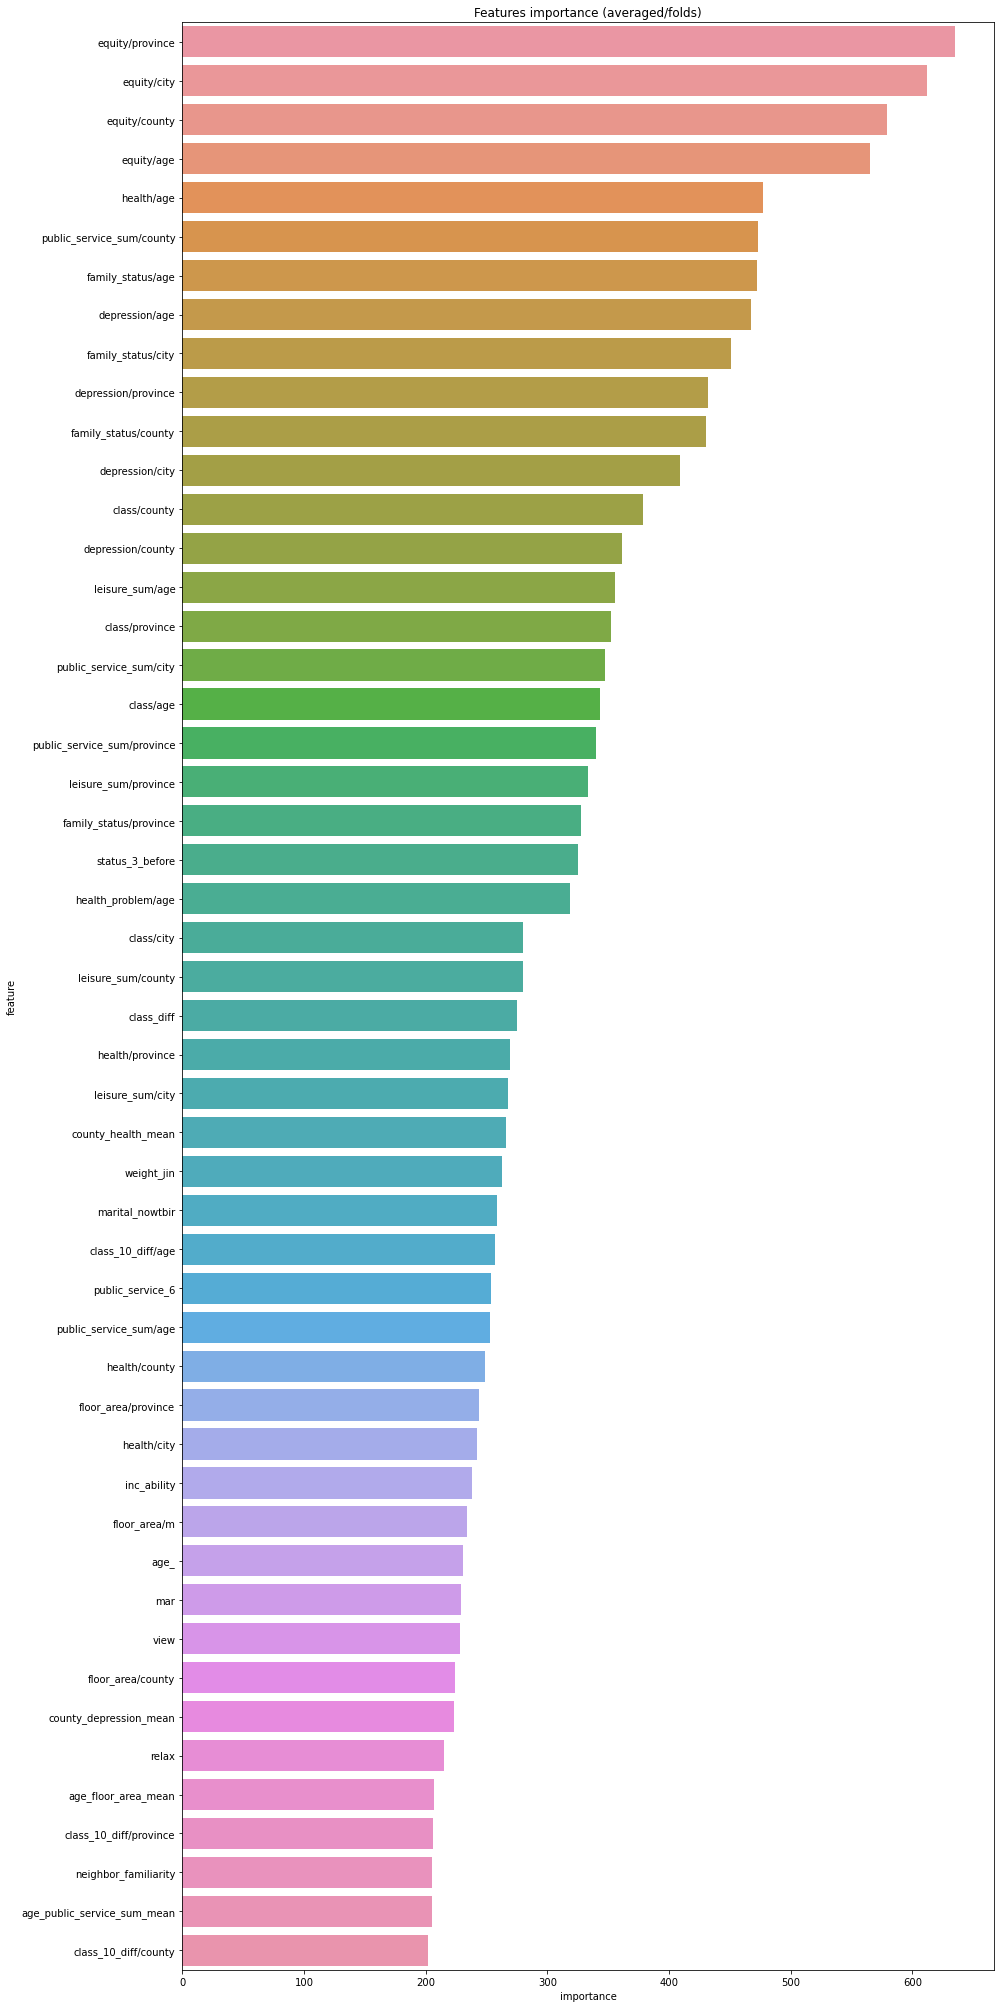

In [21]:
#---------------特征重要性
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
df = pd.DataFrame(data[use_feature].columns.tolist(), columns=['feature'])
df['importance']=list(lgb_263.feature_importance())
df = df.sort_values(by='importance',ascending=False)
plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=df.head(50))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

使用常见的机器学习方法，对于263维特征进行建模：

2. xgboost

In [22]:
##### xgb_263
#xgboost
xgb_263_params = {'eta': 0.02,  #lr
              'max_depth': 6,  
              'min_child_weight':3,#最小叶子节点样本权重和
              'gamma':0, #指定节点分裂所需的最小损失函数下降值。
              'subsample': 0.7,  #控制对于每棵树，随机采样的比例
              'colsample_bytree': 0.3,  #用来控制每棵随机采样的列数的占比 (每一列是一个特征)。
              'lambda':2,
              'objective': 'reg:linear', 
              'eval_metric': 'rmse', 
              'silent': True, 
              'nthread': -1}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_263 = np.zeros(len(X_train_263))
predictions_xgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_263[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train_263[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_263 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_263_params)
    oof_xgb_263[val_idx] = xgb_263.predict(xgb.DMatrix(X_train_263[val_idx]), ntree_limit=xgb_263.best_ntree_limit)
    predictions_xgb_263 += xgb_263.predict(xgb.DMatrix(X_test_263), ntree_limit=xgb_263.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_263, target)))

fold n°1
[22:30:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:30:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.39998	valid_data-rmse:3.40012
[500]	train-rmse:0.40684	valid_data-rmse:0.68586
[1000]	train-rmse:0.27447	valid_data-rmse:0.68726
[1180]	train-rmse:0.23710	valid_data-rmse:0.68750
fold n°2
[22:31:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:31:05] WARNING: C:/Users/Administrator/wor

3. RandomForestRegressor随机森林

In [23]:
#RandomForestRegressor随机森林
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_rfr_263 = np.zeros(len(X_train_263))
predictions_rfr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    rfr_263 = rfr(n_estimators=1600,max_depth=9, min_samples_leaf=9, min_weight_fraction_leaf=0.0,
            max_features=0.25,verbose=1,n_jobs=-1) #并行化
    #verbose = 0 为不在标准输出流输出日志信息
#verbose = 1 为输出进度条记录
#verbose = 2 为每个epoch输出一行记录
    rfr_263.fit(tr_x,tr_y)
    oof_rfr_263[val_idx] = rfr_263.predict(X_train_263[val_idx])
    
    predictions_rfr_263 += rfr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_rfr_263, target)))

fold n°1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   15.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

fold n°2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   15.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

fold n°3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   14.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

fold n°4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   15.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

fold n°5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   14.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

CV score: 0.47821594


[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1600 out of 1600 | elapsed:    0.3s finished


4. GradientBoostingRegressor梯度提升决策树

In [24]:
#GradientBoostingRegressor梯度提升决策树
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
oof_gbr_263 = np.zeros(train_shape)
predictions_gbr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    gbr_263 = gbr(n_estimators=400, learning_rate=0.01,subsample=0.65,max_depth=7, min_samples_leaf=20,
            max_features=0.22,verbose=1)
    gbr_263.fit(tr_x,tr_y)
    oof_gbr_263[val_idx] = gbr_263.predict(X_train_263[val_idx])
    
    predictions_gbr_263 += gbr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_gbr_263, target)))

fold n°1
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6501           0.0034           20.75s
         2           0.6744           0.0032           20.50s
         3           0.6503           0.0034           21.44s
         4           0.6496           0.0030           20.89s
         5           0.6422           0.0028           20.78s
         6           0.6417           0.0032           20.70s
         7           0.6413           0.0031           20.49s
         8           0.6147           0.0032           20.58s
         9           0.6338           0.0028           20.33s
        10           0.6147           0.0028           20.36s
        20           0.5914           0.0024           19.28s
        30           0.5479           0.0020           18.66s
        40           0.5552           0.0016           18.00s
        50           0.5106           0.0014           17.50s
        60           0.4958           0.0011           17.01

5. ExtraTreesRegressor 极端随机森林回归

In [25]:
#ExtraTreesRegressor 极端随机森林回归
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_etr_263 = np.zeros(train_shape)
predictions_etr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    etr_263 = etr(n_estimators=1000,max_depth=8, min_samples_leaf=12, min_weight_fraction_leaf=0.0,
            max_features=0.4,verbose=1,n_jobs=-1)# max_feature：划分时考虑的最大特征数
    etr_263.fit(tr_x,tr_y)
    oof_etr_263[val_idx] = etr_263.predict(X_train_263[val_idx])
    
    predictions_etr_263 += etr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_etr_263, target)))

fold n°1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps

fold n°2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps

fold n°3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps

fold n°4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps

fold n°5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps

CV score: 0.48629243


至此，我们得到了以上5种模型的预测结果以及模型架构及参数。其中在每一种特征工程中，进行5折的交叉验证，并重复两次（Kernel Ridge Regression，核脊回归），取得每一个特征数下的模型的结果。

在这里使用Stacking方法去建构第二层模型-Kernel Ridge Regression

In [26]:
train_stack2 = np.vstack([oof_lgb_263,oof_xgb_263,oof_gbr_263,oof_rfr_263,oof_etr_263]).transpose()
# transpose()函数的作用就是调换x,y,z的位置,也就是数组的索引值
test_stack2 = np.vstack([predictions_lgb_263, predictions_xgb_263,predictions_gbr_263,predictions_rfr_263,predictions_etr_263]).transpose()

#交叉验证:5折，重复2次
folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack2 = np.zeros(train_stack2.shape[0])
predictions_lr2 = np.zeros(test_stack2.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack2,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack2[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack2[val_idx], target.iloc[val_idx].values
    #Kernel Ridge Regression
    lr2 = kr()
    lr2.fit(trn_data, trn_y)
    
    oof_stack2[val_idx] = lr2.predict(val_data)
    predictions_lr2 += lr2.predict(test_stack2) / 10
    
mean_squared_error(target.values, oof_stack2)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.44850136412439906

接下来我们对于49维的数据进行与上述263维数据相同的操作

1. lightGBM

In [27]:
##### lgb_49
lgb_49_param = {
'num_leaves': 9,
'min_data_in_leaf': 23,
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.002,
"boosting": "gbdt",
"feature_fraction": 0.45, 
"bagging_freq": 1,
"bagging_fraction": 0.65, 
"bagging_seed": 15,
"metric": 'mse',
"lambda_l2": 0.2, 
"verbosity": -1} # 一个叶子上数据的最小数量 \ feature_fraction将会在每棵树训练之前选择 45% 的特征。可以用来加速训练，可以用来处理过拟合。 #bagging_fraction不进行重采样的情况下随机选择部分数据。可以用来加速训练，可以用来处理过拟合。
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)   
oof_lgb_49 = np.zeros(len(X_train_49))
predictions_lgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_49[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_49[val_idx], y_train[val_idx])

    num_round = 12000
    lgb_49 = lgb.train(lgb_49_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof_lgb_49[val_idx] = lgb_49.predict(X_train_49[val_idx], num_iteration=lgb_49.best_iteration)
    predictions_lgb_49 += lgb_49.predict(X_test_49, num_iteration=lgb_49.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_49, target)))

fold n°1
Training until validation scores don't improve for 1000 rounds
[1000]	training's l2: 0.471019	valid_1's l2: 0.494326
[2000]	training's l2: 0.430666	valid_1's l2: 0.474748
[3000]	training's l2: 0.408207	valid_1's l2: 0.469893
[4000]	training's l2: 0.390556	valid_1's l2: 0.46828
[5000]	training's l2: 0.375144	valid_1's l2: 0.46747
[6000]	training's l2: 0.361309	valid_1's l2: 0.467255
Early stopping, best iteration is:
[5457]	training's l2: 0.368666	valid_1's l2: 0.467017
fold n°2
Training until validation scores don't improve for 1000 rounds
[1000]	training's l2: 0.471402	valid_1's l2: 0.493843
[2000]	training's l2: 0.43052	valid_1's l2: 0.474481
[3000]	training's l2: 0.407758	valid_1's l2: 0.469914
[4000]	training's l2: 0.389637	valid_1's l2: 0.46848
[5000]	training's l2: 0.374293	valid_1's l2: 0.467984
[6000]	training's l2: 0.360368	valid_1's l2: 0.46791
[7000]	training's l2: 0.347628	valid_1's l2: 0.468419
Early stopping, best iteration is:
[6259]	training's l2: 0.356974	vali

2. xgboost

In [28]:
##### xgb_49
xgb_49_params = {'eta': 0.02, 
              'max_depth': 5, 
              'min_child_weight':3,
              'gamma':0,
              'subsample': 0.7, 
              'colsample_bytree': 0.35, 
              'lambda':2,
              'objective': 'reg:linear', 
              'eval_metric': 'rmse', 
              'silent': True, 
              'nthread': -1}


folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_49 = np.zeros(len(X_train_49))
predictions_xgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_49[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train_49[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_49 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_49_params)
    oof_xgb_49[val_idx] = xgb_49.predict(xgb.DMatrix(X_train_49[val_idx]), ntree_limit=xgb_49.best_ntree_limit)
    predictions_xgb_49 += xgb_49.predict(xgb.DMatrix(X_test_49), ntree_limit=xgb_49.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_49, target)))

fold n°1
[23:48:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:48:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.40422	valid_data-rmse:3.38325
[500]	train-rmse:0.52669	valid_data-rmse:0.71888
[1000]	train-rmse:0.43538	valid_data-rmse:0.72006
[1201]	train-rmse:0.40366	valid_data-rmse:0.72215
fold n°2
[23:48:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:48:05] WARNING: C:/Users/Administrator/wor

3. GradientBoostingRegressor梯度提升决策树

In [29]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
oof_gbr_49 = np.zeros(train_shape)
predictions_gbr_49 = np.zeros(len(X_test_49))
#GradientBoostingRegressor梯度提升决策树
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    gbr_49 = gbr(n_estimators=600, learning_rate=0.01,subsample=0.65,max_depth=6, min_samples_leaf=20,
            max_features=0.35,verbose=1)
    gbr_49.fit(tr_x,tr_y)
    oof_gbr_49[val_idx] = gbr_49.predict(X_train_49[val_idx])
    
    predictions_gbr_49 += gbr_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_gbr_49, target)))

fold n°1
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6569           0.0035           11.96s
         2           0.6822           0.0032           11.95s
         3           0.6477           0.0031           12.13s
         4           0.6430           0.0032           12.07s
         5           0.6543           0.0029           12.02s
         6           0.6607           0.0033           12.08s
         7           0.6260           0.0030           12.03s
         8           0.6242           0.0030           11.91s
         9           0.6273           0.0027           11.95s
        10           0.6247           0.0028           11.98s
        20           0.5923           0.0021           11.56s
        30           0.5886           0.0021           11.28s
        40           0.5607           0.0016           11.03s
        50           0.5450           0.0013           10.82s
        60           0.5135           0.0013           10.63

至此，我们得到了以上3种模型的基于49个特征的预测结果以及模型架构及参数。其中在每一种特征工程中，进行5折的交叉验证，并重复两次（Kernel Ridge Regression，核脊回归），取得每一个特征数下的模型的结果。

In [30]:
train_stack3 = np.vstack([oof_lgb_49,oof_xgb_49,oof_gbr_49]).transpose()
test_stack3 = np.vstack([predictions_lgb_49, predictions_xgb_49,predictions_gbr_49]).transpose()
#
folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack3 = np.zeros(train_stack3.shape[0])
predictions_lr3 = np.zeros(test_stack3.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack3,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack3[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack3[val_idx], target.iloc[val_idx].values
        #Kernel Ridge Regression
    lr3 = kr()
    lr3.fit(trn_data, trn_y)
    
    oof_stack3[val_idx] = lr3.predict(val_data)
    predictions_lr3 += lr3.predict(test_stack3) / 10
    
mean_squared_error(target.values, oof_stack3)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4673556519798529

**383维的数据进行与上述263以及49维数据相同的操作**

1. Kernel Ridge Regression 基于核的岭回归

In [31]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_kr_383 = np.zeros(train_shape)
predictions_kr_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    #Kernel Ridge Regression 岭回归
    kr_383 = kr()
    kr_383.fit(tr_x,tr_y)
    oof_kr_383[val_idx] = kr_383.predict(X_train_383[val_idx])
    
    predictions_kr_383 += kr_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_kr_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.54009041


2. 使用普通岭回归

In [32]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_ridge_383 = np.zeros(train_shape)
predictions_ridge_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    #使用岭回归
    ridge_383 = Ridge(alpha=1200)
    ridge_383.fit(tr_x,tr_y)
    oof_ridge_383[val_idx] = ridge_383.predict(X_train_383[val_idx])
    
    predictions_ridge_383 += ridge_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_ridge_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.48687670


3. 使用ElasticNet 弹性网络

In [33]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_en_383 = np.zeros(train_shape)
predictions_en_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    #ElasticNet 弹性网络
    en_383 = en(alpha=1.0,l1_ratio=0.06)
    en_383.fit(tr_x,tr_y)
    oof_en_383[val_idx] = en_383.predict(X_train_383[val_idx])
    
    predictions_en_383 += en_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_en_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.53296555


4. 使用BayesianRidge 贝叶斯岭回归

In [34]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_br_383 = np.zeros(train_shape)
predictions_br_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = y_train[trn_idx]
    #BayesianRidge 贝叶斯回归
    br_383 = br()
    br_383.fit(tr_x,tr_y)
    oof_br_383[val_idx] = br_383.predict(X_train_383[val_idx])
    
    predictions_br_383 += br_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_br_383, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.48717340


至此，我们得到了以上4种模型的基于383个特征的预测结果以及模型架构及参数。其中在每一种特征工程中，进行5折的交叉验证，并重复两次（LinearRegression简单的线性回归），取得每一个特征数下的模型的结果。

In [35]:
train_stack1 = np.vstack([oof_br_383,oof_kr_383,oof_en_383,oof_ridge_383]).transpose()
test_stack1 = np.vstack([predictions_br_383, predictions_kr_383,predictions_en_383,predictions_ridge_383]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack1 = np.zeros(train_stack1.shape[0])
predictions_lr1 = np.zeros(test_stack1.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack1,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack1[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack1[val_idx], target.iloc[val_idx].values
    # LinearRegression简单的线性回归
    lr1 = lr()
    lr1.fit(trn_data, trn_y)
    
    oof_stack1[val_idx] = lr1.predict(val_data)
    predictions_lr1 += lr1.predict(test_stack1) / 10
    
mean_squared_error(target.values, oof_stack1)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4883460396010735

### 利用更多的模型再次训练49维数据

1. KernelRidge 核岭回归

In [36]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_kr_49 = np.zeros(train_shape)
predictions_kr_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    kr_49 = kr()
    kr_49.fit(tr_x,tr_y)
    oof_kr_49[val_idx] = kr_49.predict(X_train_49[val_idx])
    
    predictions_kr_49 += kr_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_kr_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.50254991


2. Ridge 岭回归

In [37]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_ridge_49 = np.zeros(train_shape)
predictions_ridge_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    ridge_49 = Ridge(alpha=6)
    ridge_49.fit(tr_x,tr_y)
    oof_ridge_49[val_idx] = ridge_49.predict(X_train_49[val_idx])
    
    predictions_ridge_49 += ridge_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_ridge_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.49451286


3. BayesianRidge 贝叶斯岭回归

In [38]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_br_49 = np.zeros(train_shape)
predictions_br_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    br_49 = br()
    br_49.fit(tr_x,tr_y)
    oof_br_49[val_idx] = br_49.predict(X_train_49[val_idx])
    
    predictions_br_49 += br_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_br_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.49534595


4. ElasticNet 弹性网络

In [39]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_en_49 = np.zeros(train_shape)
predictions_en_49 = np.zeros(len(X_test_49))
#
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_49[trn_idx]
    tr_y = y_train[trn_idx]
    en_49 = en(alpha=1.0,l1_ratio=0.05)
    en_49.fit(tr_x,tr_y)
    oof_en_49[val_idx] = en_49.predict(X_train_49[val_idx])
    
    predictions_en_49 += en_49.predict(X_test_49) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_en_49, target)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.53841695


Stacking 训练第二层模型

In [40]:
train_stack4 = np.vstack([oof_br_49,oof_kr_49,oof_en_49,oof_ridge_49]).transpose()
test_stack4 = np.vstack([predictions_br_49, predictions_kr_49,predictions_en_49,predictions_ridge_49]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack4 = np.zeros(train_stack4.shape[0])
predictions_lr4 = np.zeros(test_stack4.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack4,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack4[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack4[val_idx], target.iloc[val_idx].values
    #LinearRegression
    lr4 = lr()
    lr4.fit(trn_data, trn_y)
    
    oof_stack4[val_idx] = lr4.predict(val_data)
    predictions_lr4 += lr4.predict(test_stack1) / 10
    
mean_squared_error(target.values, oof_stack4)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4949139981666125

## 继续Stacking

仅作参考

In [41]:
#和下面作对比
mean_squared_error(target.values, 0.7*(0.6*oof_stack2 + 0.4*oof_stack3)+0.3*(0.55*oof_stack1+0.45*oof_stack4))

0.4531767144415424

用 LinearRegression 回归

In [42]:
train_stack5 = np.vstack([oof_stack1,oof_stack2,oof_stack3,oof_stack4]).transpose()
test_stack5 = np.vstack([predictions_lr1, predictions_lr2,predictions_lr3,predictions_lr4]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack5 = np.zeros(train_stack5.shape[0])
predictions_lr5= np.zeros(test_stack5.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack5,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack5[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack5[val_idx], target.iloc[val_idx].values
    #LinearRegression
    lr5 = lr()
    lr5.fit(trn_data, trn_y)
    
    oof_stack5[val_idx] = lr5.predict(val_data)
    predictions_lr5 += lr5.predict(test_stack5) / 10
    
mean_squared_error(target.values, oof_stack5)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.4484289295558744

## 结果保存

In [43]:
predictions_lr5

array([3.82258159, 2.88475464, 3.47119513, ..., 4.00522306, 4.00204652,
       4.90848617])

In [45]:
submit_example = pd.read_csv('submit_example.csv',sep=',',encoding='latin-1')

submit_example['happiness'] = predictions_lr5

submit_example.happiness.describe()

count    2968.000000
mean        3.880151
std         0.462130
min         1.683074
25%         3.669273
50%         3.950815
75%         4.186519
max         5.047991
Name: happiness, dtype: float64

结果数据进行清理(连续值->整数值)

In [46]:
submit_example.loc[submit_example['happiness']>4.96,'happiness']= 5
submit_example.loc[submit_example['happiness']<=1.04,'happiness']= 1
submit_example.loc[(submit_example['happiness']>1.96)&(submit_example['happiness']<2.04),'happiness']= 2

submit_example.to_csv("submision.csv",index=False)
submit_example.happiness.describe()

count    2968.000000
mean        3.880139
std         0.462061
min         1.683074
25%         3.669273
50%         3.950815
75%         4.186519
max         5.000000
Name: happiness, dtype: float64

## 利用网格搜索调Hyperparameters

In [48]:
from sklearn.model_selection import GridSearchCV

参数很多，需要继续研究